In [109]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

Populating the interactive namespace from numpy and matplotlib


In [110]:
G = 6.67e-8

dt = 1e-2
stepN = 10000
h = 2e9

In [111]:
### --- Distribution Case 1 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8])) 
# nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8],
#                            [0.0, 1.0e8]))
# nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
nParticles = 100
xyzDistribution = np.random.normal(0, 5e7, size = (nParticles, 3))

# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyzDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,3,stepN), dtype=np.float)
ParticleVelocityHistory = np.zeros((nParticles,3,stepN), dtype=np.float)


timeArray = np.arange(0, stepN*dt, dt)

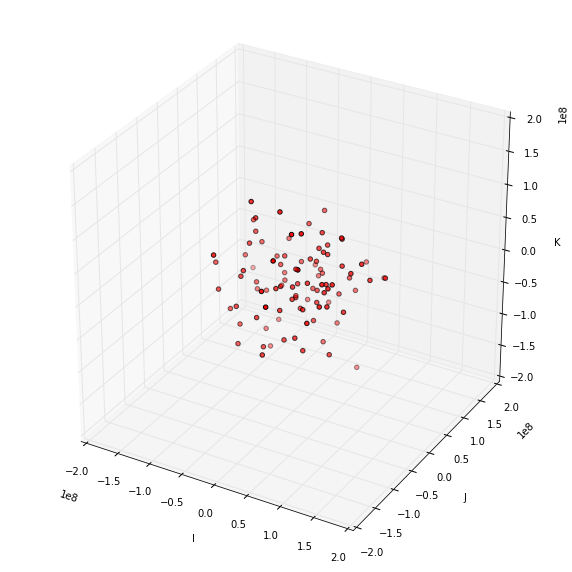

In [112]:
fig_0 = plt.figure(figsize=(10,10))
ax_0 = fig_0.add_subplot(111, projection='3d')
ax_0.scatter(xyzDistribution[:,0], xyzDistribution[:,1], xyzDistribution[:,2], c='r')

plt.xlim(-2e8, 2e8)
plt.ylim(-2e8, 2e8)
ax_0.set_zlim(-2e8,2e8)
ax_0.set_xlabel('I')
ax_0.set_ylabel('J')
ax_0.set_zlabel('K')

#print(xyzDistribution)

In [113]:
def gravity(xyzDistribution, t):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyzDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyzDistribution[j,0]-xyzDistribution[k,0])
                ydist = (xyzDistribution[j,1]-xyzDistribution[k,1])
                zdist = (xyzDistribution[j,2]-xyzDistribution[k,2])
#                 print "time step ", t
#                 print "z distance ", zdist
#                 print "y distance ", ydist
#                 print "x distance ", xdist
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

# X Component of Force
                if(abs(xdist)<1e7):
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
                #print "distance ", (np.sqrt(xdist**2+ydist**2+zdist**2))

# Y Component of Force
                if(abs(ydist)<1e7):
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)

# Z Component of Force
                if(abs(zdist)<1e7):
                    deltaV[j,2] -= 0
#                    print "Z less than smoothing"
                else:
                    deltaV[j,2] += -G*mDistribution[j]*zdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
    

    #print(deltaV)
    return deltaV

nb_gravity = nb.autojit(gravity)

In [114]:
# RK1 Parameters
t0 = time.time()
t = 0
#dt = 1e1
#stepN = 20

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,3), dtype=np.float)
ParticleRhoHistory = np.zeros((stepN, nParticles, 1), dtype=np.float)
xyzDistributionOld = np.copy(xyzDistribution)
# Velocity History
ParticleVelocityHistory = np.zeros((stepN,nParticles,3))

# Force history
forceHistory = np.zeros((stepN, 3), dtype=np.float)

deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)

for i in range(stepN):
    if i % 50 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyzDistribution
    ParticleVelocityHistory[i,:,:] = velocityDistribution
    
    deltaVf += nb_gravity(xyzDistribution, i) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.median(deltaVf)
    
    
#     deltaVf -= -gradP()/rhoDistribution[:,np.newaxis]
# #    print "Avg gravity + pressure", np.mean(deltaVf)
#     forceHistory[i,1] = np.mean(deltaVf)

#    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
#    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)
    
    velocityDistribution += dt*deltaVf    
    xyzDistribution += dt*velocityDistribution

#    densityUpdate()
#    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
#    pressureDistribution = K*rhoDistribution**2

    ### --- DEBUGGING --- ###
#    print xyDistribution[0,0] - xyDistribution[1,0]


print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 50
Time step 100
Time step 150
Time step 200
Time step 250
Time step 300
Time step 350
Time step 400
Time step 450
Time step 500
Time step 550
Time step 600
Time step 650
Time step 700
Time step 750
Time step 800
Time step 850
Time step 900
Time step 950
Time step 1000
Time step 1050
Time step 1100
Time step 1150
Time step 1200
Time step 1250
Time step 1300
Time step 1350
Time step 1400
Time step 1450
Time step 1500
Time step 1550
Time step 1600
Time step 1650
Time step 1700
Time step 1750
Time step 1800
Time step 1850
Time step 1900
Time step 1950
Time step 2000
Time step 2050
Time step 2100
Time step 2150
Time step 2200
Time step 2250
Time step 2300
Time step 2350
Time step 2400
Time step 2450
Time step 2500
Time step 2550
Time step 2600
Time step 2650
Time step 2700
Time step 2750
Time step 2800
Time step 2850
Time step 2900
Time step 2950
Time step 3000
Time step 3050
Time step 3100
Time step 3150
Time step 3200
Time step 3250
Time step 3300
Time step 3350
Tim

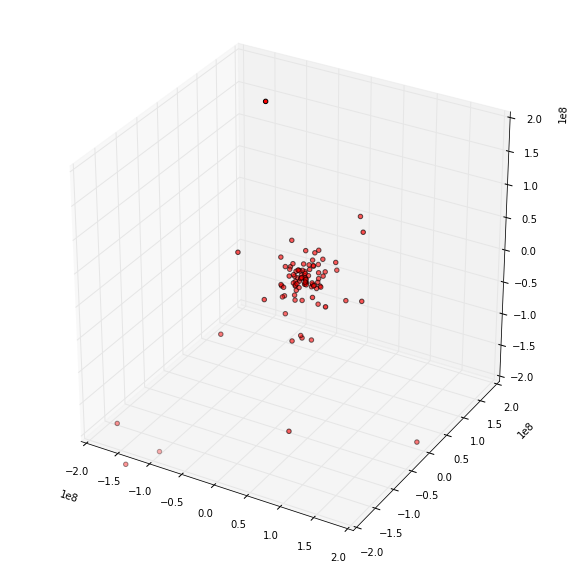

In [115]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=int(slider.value)
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    z = ParticlePositionHistory[time-1,:,2]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='r')
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e8,2e8)
    plt.ylim(-2e8,2e8)
    ax.set_zlim(-2e8,2e8)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

[[  1.15327868e+07  -4.28772838e+06   5.75272268e+07]
 [  1.12950033e+08  -1.35784224e+08  -7.38929000e+06]
 [  1.03398456e+07  -1.90601217e+07   3.04111527e+07]
 [  2.94537631e+07  -7.70692862e+07   2.55953461e+07]
 [ -2.61228419e+06   4.10752349e+07  -1.44413407e+07]
 [ -2.56368130e+08  -6.51348696e+08   1.26215270e+08]
 [  3.89052743e+08   3.48536453e+08   2.87795888e+08]
 [ -3.85166553e+08   2.19224738e+08  -5.66897767e+08]
 [  4.69171929e+07  -2.68339102e+07   2.83987812e+07]
 [ -6.98316564e+06  -4.40492603e+07   1.67870445e+07]
 [  3.74300237e+07  -7.58344498e+06   1.03577539e+08]
 [ -5.97748343e+07   8.45047929e+07   3.67944903e+06]
 [ -3.16011043e+07   4.07486436e+07   8.16172012e+07]
 [  6.38543414e+07   2.47824174e+07   8.49196667e+07]
 [  3.61752211e+07  -1.15275340e+07   5.04977156e+07]
 [ -1.18711017e+06  -5.48151928e+06   1.37979492e+07]
 [ -3.21395808e+07   5.43348110e+05  -8.30317889e+06]
 [  8.67444194e+07   5.97328348e+07   1.25325063e+07]
 [ -5.54440971e+06  -1.90186

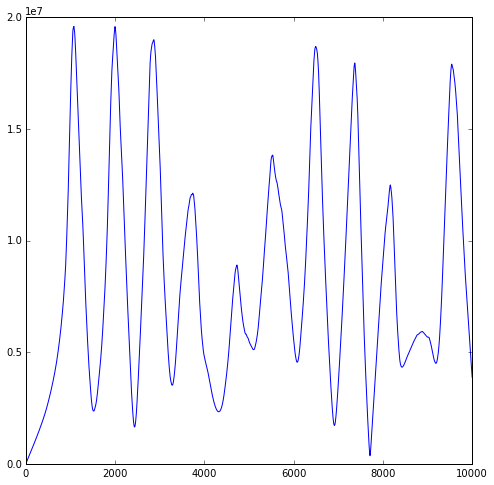

In [116]:
plt.figure(figsize=(8,8))
# plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), abs(np.sqrt((ParticleVelocityHistory[:,0,0])**2+(ParticleVelocityHistory[:,0,1])**2)))
print(xyzDistribution-xyzDistributionOld)

Velocity Asymptotes $\implies$ Force goes to zero (Good thing)

In [117]:
def gradW(xyzDist, h):
    '''
    Inputs:
        xyzDist: a [3,1] array containing the difference in [x,y,z] position
            between two particles
        h: smoothing length
    Outputs:
        a [3,1] array containing the [x,y,z] component of gradW
    '''
    
    dist = np.sqrt(xyzDist[0]**2 + xyzDist[1]**2 + xyzDist[2]**2)
    
    if dist < h:
        return np.array(
                [3*xyzDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[1]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[2]*(3*dist - 4*h)/(4*np.pi*h**6)])
    
    # 2D kernel
#         return np.array(
#               [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
#                15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0,0])
    
    else:
        return np.array(
                [-3*xyzDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyzDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist)
                 -3*xyzDist[2]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])
    
#         return np.array(
#                 [-15*xyDist[0]*(2*h - dist)**2/(14*h**5*np.pi*dist),
#                  -15*xyDist[1]*(2*h - dist)**2/(14*h**5*np.pi*dist)] )

SyntaxError: invalid syntax (<ipython-input-117-07d33d8d53b7>, line 17)